### Packages used

In [36]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import string
import time
from tqdm import tqdm

### Load Datasets

In [37]:
players_with_stats = pd.read_csv('~/Desktop/Stats/hof/players_with_stats.csv')
df = pd.read_csv('~/Desktop/Stats/hof/nba_players.csv')

### Code to get player data (don't need to run again)

In [2]:
def get_player_table():
    players = []
    url = 'https://www.basketball-reference.com/players/'
    
    for letter in string.ascii_lowercase:
        page_request = requests.get(url + letter)
        soup = BeautifulSoup(page_request.text, "html5lib")
        table = soup.find("table")
        if table:
            table_body = table.find("tbody")
            for row in table_body.findAll("tr"):
                player_url = row.find("a")
                player_name = player_url.text
                player_page = player_url["href"]
                
                cells = row.findAll("td")
                active_from = int(cells[0].text)
                active_to = int(cells[1].text)
                pos = cells[2].text
                height = cells[3].text
                weight = cells[4].text
                birth_date = cells[5].text
                college = cells[6].text
                
                player = {'url': player_page, 
                          'name': player_name, 
                          'active_from': active_from,  
                          'active_to': active_to, 
                          'position': pos, 
                          'height': height, 
                          'weight': weight, 
                          'birth_date': birth_date, 
                          'college': college}
                players.append(player)
                
    return pd.DataFrame(players)

In [29]:
def get_player_stats(url):
    cols = ['G', 'MP', 'FG', 'FGA', 'FG%', 'FT', 'FTA', 'FT%', 'TRB', 'AST', 'PTS']
    base_url = 'https://www.basketball-reference.com/players/'
    page_request = requests.get('https://www.basketball-reference.com' + url)
    soup = BeautifulSoup(page_request.text, "html5lib")
    table = soup.find("table")
    if table:
        table_header = table.find("thead")
        table_cols = [col.text for col in table_header.findAll("th")]
        col_indices = [table_cols.index(col) for col in cols]
        col_indices = [index - 1 for index in col_indices]
        
        table_footer = table.find("tfoot")
        cells = table_footer.findAll("td")
        #print(cells)
        games_played = int(cells[col_indices[0]].text)
        #games_started = int(cells[5].text)
        mpg = 0.0
        if cells[col_indices[1]].text != '':
            mpg = float(cells[col_indices[1]].text)
        else:
            mpg = float('nan')
        fgm = float(cells[col_indices[2]].text)
        fga = float(cells[col_indices[3]].text)
        fg_pct = 0.0
        if cells[col_indices[4]].text != '':
            fg_pct = float(cells[col_indices[4]].text)
        else:
            fg_pct = float('nan')
        #three_pm = float(cells[10].text)
        #three_pa = float(cells[11].text)
        #three_pct = float(cells[12].text)
        #two_pm = float(cells[13].text)
        #two_pa = float(cells[14].text)
        #two_pct = float(cells[15].text)
        #efg_pct = float(cells[16].text)
        ftm = float(cells[col_indices[5]].text)
        fta = float(cells[col_indices[6]].text)
        ft_pct = 0.0
        if cells[col_indices[7]].text != '':
            ft_pct = float(cells[col_indices[7]].text)
        else:
            ft_pct = float('nan')
        #orb = float(cells[20].text)
        #drb = float(cells[21].text)
        trb = 0.0
        if cells[col_indices[8]].text != '':
            trb = float(cells[col_indices[8]].text)
        else:
            trb = float('nan')
        ast = float(cells[col_indices[9]].text)
        #stl = float(cells[24].text)
        #blk = float(cells[25].text)
        #tov = float(cells[26].text)
        #pf = float(cells[27].text)
        pts = float(cells[col_indices[10]].text)
        
        player = {'games_played': games_played, 
                  #'games_started': games_started, 
                  'mpg': mpg,  
                  'fgm': fgm, 
                  'fga': fga, 
                  'fg_pct': fg_pct, 
                  #'three_pm': three_pm, 
                  #'three_pa': three_pa, 
                  #'three_pct': three_pct,
                  #'two_pm': two_pm, 
                  #'two_pa': two_pa, 
                  #'two_pct': two_pct,  
                  #'efg_pct': efg_pct, 
                  'ftm': ftm, 
                  'fta': fta, 
                  'ft_pct': ft_pct, 
                  #'orb': orb, 
                  #'drb': drb,
                  'trb': trb, 
                  'ast': ast, 
                  #'stl': stl,  
                  #'blk': blk, 
                  #'tov': tov, 
                  #'pf': pf, 
                  'pts': pts}
        return player

In [43]:
from bs4 import BeautifulSoup
import requests
import re

In [44]:
def get_ncaa_champs(): 
    ncaa_champions = []
    comm = re.compile("<!--|-->")
    url = 'https://www.sports-reference.com/cbb/postseason/index.html'
    page_request = requests.get(url)
    soup_ncaa = BeautifulSoup(comm.sub("", page_request.text), "html5lib")
    ncaa_table = soup_ncaa.find('table')
    if ncaa_table:
        ncaa_table_body = ncaa_table.find('tbody')
        years = [int(year.text[:4]) for year in ncaa_table_body.findAll('th', {'data-stat':'ncaa_tourney'}) if year.text != '']
        schools = [school.text.lower() for school in ncaa_table_body.findAll('td', {'data-stat':'ncaa_champ'})]
        ncaa_champions = [school + ' ' + str(year) for school, year in zip(schools, years)]
    return ncaa_champions

In [49]:
def get_awards(url, ncaa_champs): 
    player = {}
    comm = re.compile("<!--|-->")
    page_request = requests.get('https://www.basketball-reference.com' + url)
    soup = BeautifulSoup(comm.sub("", page_request.text), "html5lib")
    table = soup.find('table')

    if table:
        table_body = table.find('tbody')
        stars = table_body.findAll('span', {'class':'sr_star'})
        player['num_all_stars'] = len(stars)
    else:
        player['num_all_stars'] = 0

    playoffs_table = soup.find('table', id='playoffs_totals')
    if playoffs_table:
        playoffs_table_body = playoffs_table.find('tbody')
        rings = playoffs_table_body.findAll('span', {'class':'sr_ring'})
        player['num_championships'] = len(rings)
    else: 
        player['num_championships'] = 0

    awards = soup.find('div', {'id':'all_leaderboard'})
    if awards:
        mvps = awards.findAll('a', {'href':'/awards/mvp.html'})
        finals_mvps = awards.findAll('a', {'href':'/awards/finals_mvp.html'})
        dpoys = awards.findAll('a', {'href':'/awards/dpoy.html'})
        smoys = awards.findAll('a', {'href':'/awards/smoy.html'})
        player['mvps'] = len(mvps)
        player['finals_mvps'] = len(finals_mvps)
        player['dpoys'] = len(dpoys)
        player['smoys'] = len(smoys)
    else:
        player['mvps'] = 0
        player['finals_mvps'] = 0
        player['dpoys'] = 0
        player['smoys'] = 0

    college_table = soup.find('table', {'id':'all_college_stats'})
    if college_table:
        college_table_body = college_table.find('tbody')
        years = [int(year.text[:4]) + 1 for year in college_table_body.findAll('th', {'data-stat':'season'})]
        schools = [school.text.lower() for school in college_table_body.findAll('td', {'data-stat':'college_id'})]
        if 'michiganst' in schools:
            schools = ['michigan state' if school == 'michiganst' else school for school in schools]
        elif 'ncstate' in schools:
            schools = ['north carolina state' if school == 'ncstate' else school for school in schools]
        elif 'ohiost' in schools:
            schools = ['ohio state' if school == 'ohiost' else school for school in schools]
        elif 'sanfran' in schools:
            schools = ['san francisco' if school == 'sanfran' else school for school in schools]
        school_years = [school + ' ' + str(year) for school, year in zip(schools, years)]



        champ_count = 0
        for sy in school_years:
            if sy in ncaa_champions:
                champ_count += 1
        player['ncaa_championships'] = champ_count
        
    info = soup.find('div', {'id':'info'})
    if info:
        hof = info.findAll('a', {'href':'/awards/hof.html'})
        player['hof'] = len(hof)
    else:
        player['hof'] = 0
        
    return player

In [32]:
import time
from tqdm import tqdm
if __name__ == '__main__':
    players = get_player_table()
    display(players.head())
    player_stats = []
    for i, url in tqdm(enumerate(players.url)):
        #print(url)
        player_stats.append(get_player_stats(url))
    player_stats = pd.DataFrame(player_stats)
    display(player_stats.head())

,active_from,active_to,birth_date,college,height,name,position,url,weight
0,1991,1995,"June 24, 1968",Duke University,6-10,Alaa Abdelnaby,F-C,/players/a/abdelal01.html,240
1,1969,1978,"April 7, 1946",Iowa State University,6-9,Zaid Abdul-Aziz,C-F,/players/a/abdulza01.html,235
2,1970,1989,"April 16, 1947","University of California, Los Angeles",7-2,Kareem Abdul-Jabbar,C,/players/a/abdulka01.html,225
3,1991,2001,"March 9, 1969",Louisiana State University,6-1,Mahmoud Abdul-Rauf,G,/players/a/abdulma02.html,162
4,1998,2003,"November 3, 1974","University of Michigan, San Jose State University",6-6,Tariq Abdul-Wahad,F,/players/a/abdulta01.html,223


4580it [52:17,  1.46it/s]


,ast,fg_pct,fga,fgm,ft_pct,fta,ftm,games_played,mpg,pts,trb
0,0.3,0.502,4.8,2.4,0.701,1.3,0.9,256,12.5,5.7,3.3
1,1.2,0.428,8.2,3.5,0.728,2.8,2.0,505,21.8,9.0,8.0
2,3.6,0.559,18.1,10.2,0.721,6.0,4.3,1560,36.8,24.6,11.2
3,3.5,0.442,13.6,6.0,0.905,2.0,1.8,586,26.7,14.6,1.9
4,1.1,0.417,7.3,3.1,0.703,2.2,1.6,236,20.4,7.8,3.3


In [40]:
players_with_stats = pd.concat([players, player_stats], axis = 1)

In [41]:
players_with_stats.head()

,active_from,active_to,birth_date,college,height,name,position,url,weight,ast,fg_pct,fga,fgm,ft_pct,fta,ftm,games_played,mpg,pts,trb
0,1991,1995,"June 24, 1968",Duke University,6-10,Alaa Abdelnaby,F-C,/players/a/abdelal01.html,240,0.3,0.502,4.8,2.4,0.701,1.3,0.9,256,12.5,5.7,3.3
1,1969,1978,"April 7, 1946",Iowa State University,6-9,Zaid Abdul-Aziz,C-F,/players/a/abdulza01.html,235,1.2,0.428,8.2,3.5,0.728,2.8,2.0,505,21.8,9.0,8.0
2,1970,1989,"April 16, 1947","University of California, Los Angeles",7-2,Kareem Abdul-Jabbar,C,/players/a/abdulka01.html,225,3.6,0.559,18.1,10.2,0.721,6.0,4.3,1560,36.8,24.6,11.2
3,1991,2001,"March 9, 1969",Louisiana State University,6-1,Mahmoud Abdul-Rauf,G,/players/a/abdulma02.html,162,3.5,0.442,13.6,6.0,0.905,2.0,1.8,586,26.7,14.6,1.9
4,1998,2003,"November 3, 1974","University of Michigan, San Jose State University",6-6,Tariq Abdul-Wahad,F,/players/a/abdulta01.html,223,1.1,0.417,7.3,3.1,0.703,2.2,1.6,236,20.4,7.8,3.3


In [50]:
import time
from tqdm import tqdm
player_award_stats = []
ncaa_champs = get_ncaa_champs()
for i, url in tqdm(enumerate(players.url)):
    player_award_stats.append(get_awards(url, ncaa_champs))
player_awards = pd.DataFrame(player_award_stats)
display(player_awards.head())

4580it [2:02:49,  1.61s/it]


,dpoys,finals_mvps,hof,mvps,ncaa_championships,num_all_stars,num_championships,smoys
0,0,0,0,0,0.0,0,0,0
1,0,0,0,0,NaN,0,0,0
2,0,2,1,6,3.0,19,6,0
3,0,0,0,0,0.0,0,0,0
4,0,0,0,0,0.0,0,0,0


In [51]:
df = pd.concat([players_with_stats, player_awards], axis = 1)

In [52]:
display(df)

,active_from,active_to,birth_date,college,height,name,position,url,weight,ast,...,pts,trb,dpoys,finals_mvps,hof,mvps,ncaa_championships,num_all_stars,num_championships,smoys
0,1991,1995,"June 24, 1968",Duke University,6-10,Alaa Abdelnaby,F-C,/players/a/abdelal01.html,240,0.3,...,5.7,3.3,0,0,0,0,0.0,0,0,0
1,1969,1978,"April 7, 1946",Iowa State University,6-9,Zaid Abdul-Aziz,C-F,/players/a/abdulza01.html,235,1.2,...,9.0,8.0,0,0,0,0,NaN,0,0,0
2,1970,1989,"April 16, 1947","University of California, Los Angeles",7-2,Kareem Abdul-Jabbar,C,/players/a/abdulka01.html,225,3.6,...,24.6,11.2,0,2,1,6,3.0,19,6,0
3,1991,2001,"March 9, 1969",Louisiana State University,6-1,Mahmoud Abdul-Rauf,G,/players/a/abdulma02.html,162,3.5,...,14.6,1.9,0,0,0,0,0.0,0,0,0
4,1998,2003,"November 3, 1974","University of Michigan, San Jose State University",6-6,Tariq Abdul-Wahad,F,/players/a/abdulta01.html,223,1.1,...,7.8,3.3,0,0,0,0,0.0,0,0,0


In [55]:
# Move hof feature to end of data frame
hof = df.pop('hof')
df['hof'] = hof
df.head()

,active_from,active_to,birth_date,college,height,name,position,url,weight,ast,...,pts,trb,dpoys,finals_mvps,mvps,ncaa_championships,num_all_stars,num_championships,smoys,hof
0,1991,1995,"June 24, 1968",Duke University,6-10,Alaa Abdelnaby,F-C,/players/a/abdelal01.html,240,0.3,...,5.7,3.3,0,0,0,0.0,0,0,0,0
1,1969,1978,"April 7, 1946",Iowa State University,6-9,Zaid Abdul-Aziz,C-F,/players/a/abdulza01.html,235,1.2,...,9.0,8.0,0,0,0,NaN,0,0,0,0
2,1970,1989,"April 16, 1947","University of California, Los Angeles",7-2,Kareem Abdul-Jabbar,C,/players/a/abdulka01.html,225,3.6,...,24.6,11.2,0,2,6,3.0,19,6,0,1
3,1991,2001,"March 9, 1969",Louisiana State University,6-1,Mahmoud Abdul-Rauf,G,/players/a/abdulma02.html,162,3.5,...,14.6,1.9,0,0,0,0.0,0,0,0,0
4,1998,2003,"November 3, 1974","University of Michigan, San Jose State University",6-6,Tariq Abdul-Wahad,F,/players/a/abdulta01.html,223,1.1,...,7.8,3.3,0,0,0,0.0,0,0,0,0


### Exploratory Analysis

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

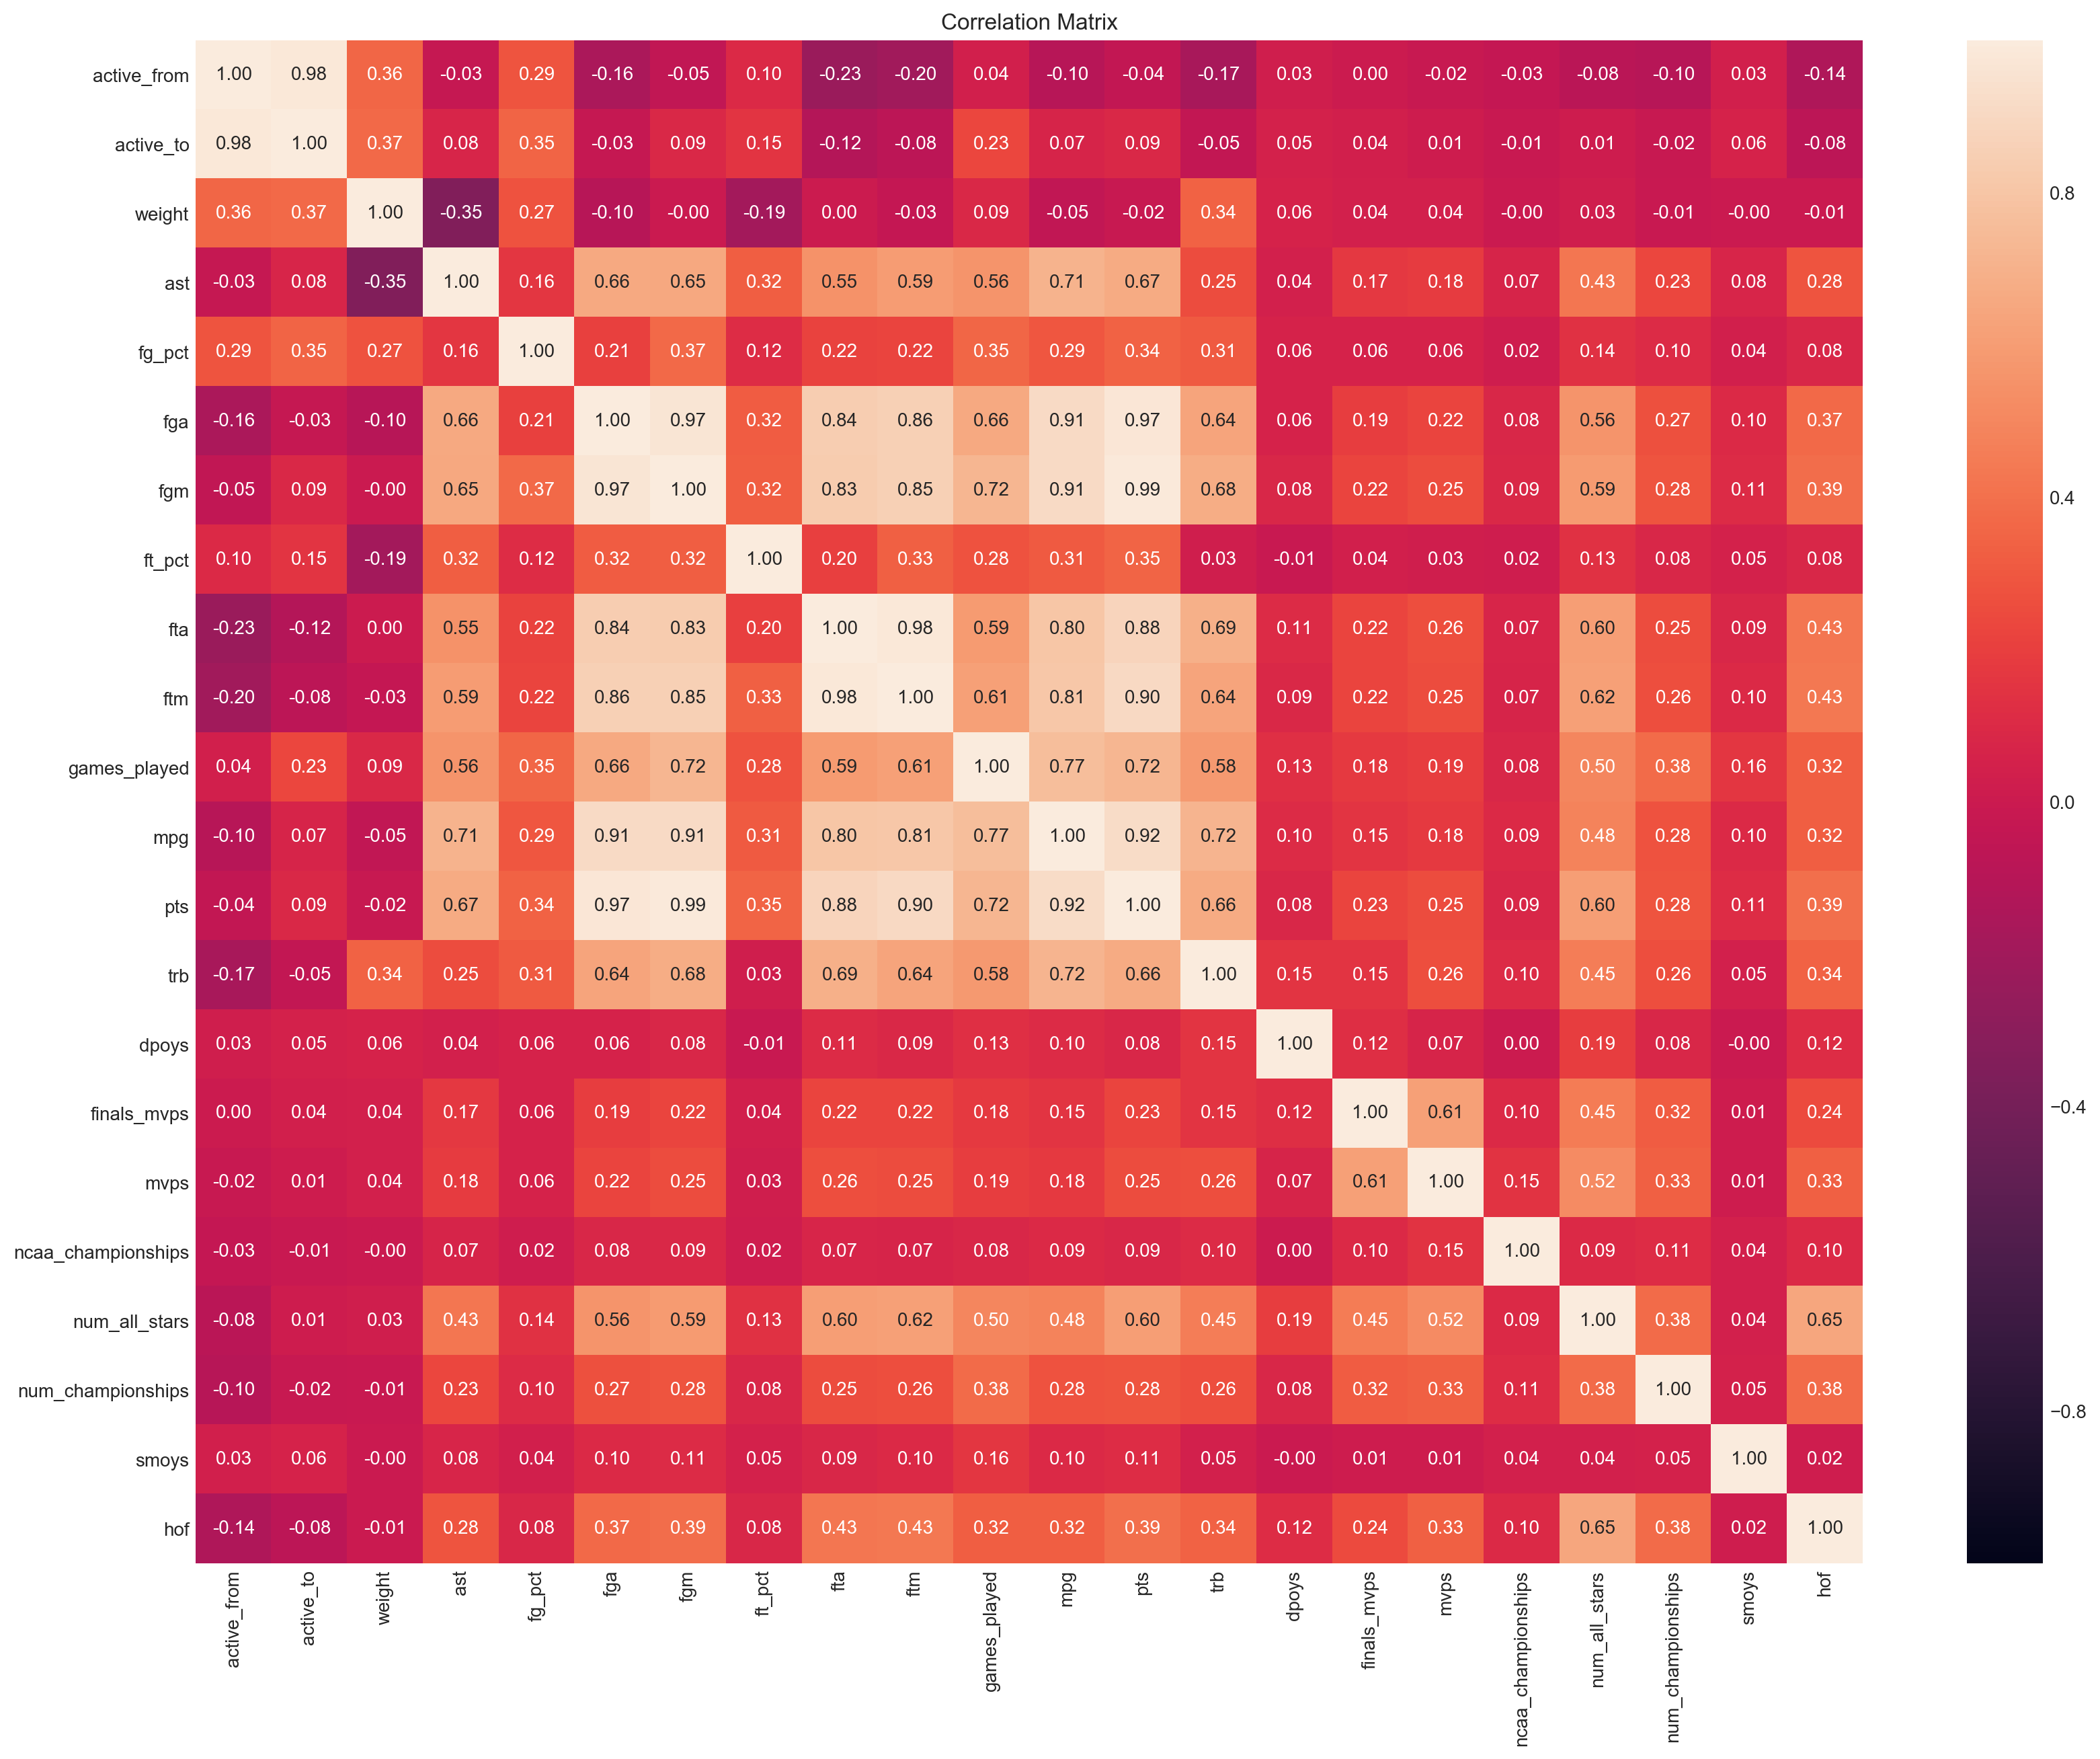

In [35]:
plt.figure(figsize = (20, 15), dpi = 200)
plt.title('Correlation Matrix')
sns.heatmap(df.corr(), annot = True, vmin = -1, vmax = 1, fmt = '.2f')
#plt.savefig('corr.png')

In [20]:
df.corr()

,active_from,active_to,weight,ast,fg_pct,fga,fgm,ft_pct,fta,ftm,...,pts,trb,dpoys,finals_mvps,mvps,ncaa_championships,num_all_stars,num_championships,smoys,hof
active_from,1.000000,0.978937,0.357195,-0.028134,0.287002,-0.155591,-0.047481,0.100718,-0.233638,-0.196598,...,-0.044882,-0.168969,0.027801,0.002898,-0.020834,-0.032836,-0.079554,-0.099110,0.031477,-0.138500
active_to,0.978937,1.000000,0.367201,0.075774,0.349079,-0.030822,0.087076,0.150000,-0.117165,-0.076737,...,0.089143,-0.046237,0.051628,0.036614,0.014913,-0.011068,0.013367,-0.022707,0.061589,-0.075240
weight,0.357195,0.367201,1.000000,-0.346959,0.274338,-0.099802,-0.004290,-0.189257,0.003408,-0.034109,...,-0.017556,0.340969,0.056237,0.044801,0.041811,-0.002957,0.031194,-0.009891,-0.002496,-0.007466
ast,-0.028134,0.075774,-0.346959,1.000000,0.162623,0.661241,0.652312,0.322255,0.552648,0.594727,...,0.668125,0.252898,0.039569,0.167758,0.180903,0.066983,0.428445,0.231390,0.076167,0.284312
fg_pct,0.287002,0.349079,0.274338,0.162623,1.000000,0.210293,0.372738,0.116390,0.216866,0.221283,...,0.343054,0.311042,0.055940,0.058516,0.062336,0.016638,0.140149,0.101948,0.038505,0.079587
fga,-0.155591,-0.030822,-0.099802,0.661241,0.210293,1.000000,0.968273,0.318542,0.839913,0.857145,...,0.968920,0.639851,0.059320,0.192915,0.219614,0.083838,0.555037,0.269924,0.097439,0.372712
fgm,-0.047481,0.087076,-0.004290,0.652312,0.372738,0.968273,1.000000,0.324026,0.834653,0.854463,...,0.991252,0.675392,0.080403,0.221968,0.250921,0.090687,0.590588,0.284924,0.105632,0.386963
ft_pct,0.100718,0.150000,-0.189257,0.322255,0.116390,0.318542,0.324026,1.000000,0.200041,0.332123,...,0.350899,0.025030,-0.010315,0.037507,0.027350,0.020339,0.134041,0.084559,0.052223,0.079846
fta,-0.233638,-0.117165,0.003408,0.552648,0.216866,0.839913,0.834653,0.200041,1.000000,0.981227,...,0.877191,0.690266,0.107615,0.221521,0.261920,0.073765,0.603085,0.253406,0.085311,0.427253
ftm,-0.196598,-0.076737,-0.034109,0.594727,0.221283,0.857145,0.854463,0.332123,0.981227,1.000000,...,0.901798,0.635190,0.091371,0.222419,0.250129,0.068556,0.616216,0.258204,0.096944,0.429940
